In [1]:
#!/use/bin/env python3.8.5

In [2]:
import numpy as np
import torch
import os

import torchvision
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import datetime
from torchstat import stat

from matplotlib import pyplot as plt
import joblib

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, (5,5), bias = None)
        self.conv2 = nn.Conv2d(6, 16, (5,5), bias = None)
        self.fc1   = nn.Linear(16*5*5, 128, bias = None)
        self.fc2   = nn.Linear(128, 84, bias = None)
        self.fc3   = nn.Linear(84, 10, bias = None)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, targets):
        loss = ((outputs - targets)**4).mean()
        return loss   

In [4]:
def test(net, test_loader, criterion, dtype=torch.float32):
    test_acc = 0
    test_loss = 0
    net.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.to(dtype)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()/len(test_loader)
            acc = (outputs.argmax(dim=1) == labels).float().mean()
            test_acc += acc/len(test_loader)
    return test_acc, test_loss

In [5]:
def test_grad(net, test_loader, train_loader, criterion, dtype=torch.float32):
    test_acc = 0
    test_loss = 0
    net.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.to(dtype)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()/len(test_loader)
            acc = (outputs.argmax(dim=1) == labels).float().mean()
            test_acc += acc/len(test_loader)
    net.train()
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        inputs = inputs.to(dtype)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
    return test_acc, test_loss

In [6]:
def to_int8(net_g,LOG):
    net_g.conv1.weight.data = (net_g.conv1.weight.data*128).to(torch.int8).to(torch.float16)/128
    net_g.conv2.weight.data = (net_g.conv2.weight.data*128).to(torch.int8).to(torch.float16)/128
    net_g.fc1.weight.data = (net_g.fc1.weight.data*128).to(torch.int8).to(torch.float16)/128
    net_g.fc2.weight.data = (net_g.fc2.weight.data*128).to(torch.int8).to(torch.float16)/128
    net_g.fc3.weight.data = (net_g.fc3.weight.data*128).to(torch.int8).to(torch.float16)/128
    LOG.append("to int8")

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 200
DL = False
train_set = torchvision.datasets.CIFAR10(root='~/work2/workspace/datasets/CIFAR-10', 
                                        train=True,
                                        download=DL,
                                        transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='~/work2/workspace/datasets/CIFAR-10/', 
                                        train=False, 
                                        download=DL, 
                                        transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, 
                                            batch_size=batch_size,
                                            shuffle=False, 
                                            num_workers=2)
classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
LOG = []
net_g = LeNet()
net_g.to(device)
net_g.conv1.weight.data = net_g.conv1.weight.data.to(torch.float16)
net_g.conv2.weight.data = net_g.conv2.weight.data.to(torch.float16)
net_g.fc1.weight.data = net_g.fc1.weight.data.to(torch.float16)
net_g.fc2.weight.data = net_g.fc2.weight.data.to(torch.float16)
net_g.fc3.weight.data = net_g.fc3.weight.data.to(torch.float16)
LOG.append("init float16")
cur = 0

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_g.parameters(), lr=0.001, momentum=0.9)

In [11]:
epochs = 100
count = 0
saturated = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_acc = 0
    epoch_test_loss = 0
    epoch_test_acc = 0
    net_g.train()
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.to(torch.float16)
        optimizer.zero_grad()
        outputs = net_g(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()/len(train_loader)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        epoch_train_acc += acc/len(train_loader)
    net_g.eval()
    to_int8(net_g,LOG)
    epoch_test_acc, epoch_test_loss = test(net_g, test_loader, criterion, torch.float16)
    print(f'Epoch {epoch+1} : train acc. {epoch_train_acc:.3f} train loss {epoch_train_loss:.3f}')
    print(f'Epoch {epoch+1} : test acc. {epoch_test_acc:.3f} test loss {epoch_test_loss:.3f}')
    if cur < epoch_test_acc:
        cur = epoch_test_acc
        MODEL_HOME = "/home/y-neo/work2/workspace/docker/workspace/LeNet_CIFAR10"
        model_path = MODEL_HOME + '/model_trainingp.pth'
        torch.save(net_g.state_dict(), model_path)
    else:
        saturated += 1
        if saturated > 3:
            print("break")
            break

Epoch 1 : train acc. 0.109 train loss 2.303
Epoch 1 : test acc. 0.102 test loss 2.303
Epoch 2 : train acc. 0.111 train loss 2.303
Epoch 2 : test acc. 0.123 test loss 2.302
Epoch 3 : train acc. 0.127 train loss 2.302
Epoch 3 : test acc. 0.126 test loss 2.302


KeyboardInterrupt: 

In [134]:
net_g.eval()
to_int8(net_g,LOG)
test_acc, test_loss = test(net_g, test_loader, criterion, torch.float16)
print(f' test acc. {test_acc:.3f} test loss {test_loss:.3f}')

 test acc. 0.581 test loss 1.217


In [133]:
MODEL_HOME = "/home/y-neo/work2/workspace/docker/workspace/LeNet_CIFAR10"
model_path = MODEL_HOME + '/model_training.pth'
net_g.load_state_dict(torch.load(model_path))
LOG = []
LOG.append(model_path)

In [ ]:
MODEL_HOME = "/home/y-neo/work2/workspace/docker/workspace/LeNet_CIFAR10"
model_path = MODEL_HOME + '/model.pth'
torch.save(net_g.state_dict(), model_path)

Ans = truck, LeNet_Ans = airplane
Ans = dog, LeNet_Ans = dog
Ans = automobile, LeNet_Ans = automobile
Ans = cat, LeNet_Ans = deer
Ans = ship, LeNet_Ans = ship
Ans = horse, LeNet_Ans = deer
Ans = bird, LeNet_Ans = frog
Ans = dog, LeNet_Ans = dog
Ans = automobile, LeNet_Ans = automobile
Ans = horse, LeNet_Ans = horse
Ans = frog, LeNet_Ans = truck
Ans = horse, LeNet_Ans = dog
Ans = cat, LeNet_Ans = dog
Ans = airplane, LeNet_Ans = truck
Ans = dog, LeNet_Ans = dog
Ans = deer, LeNet_Ans = bird
Ans = horse, LeNet_Ans = horse
Ans = dog, LeNet_Ans = dog
Ans = ship, LeNet_Ans = automobile
Ans = airplane, LeNet_Ans = airplane
Ans = horse, LeNet_Ans = horse
Ans = deer, LeNet_Ans = cat
Ans = horse, LeNet_Ans = horse
Ans = cat, LeNet_Ans = frog
Ans = horse, LeNet_Ans = bird
Ans = dog, LeNet_Ans = horse
Ans = deer, LeNet_Ans = dog
Ans = cat, LeNet_Ans = frog
Ans = deer, LeNet_Ans = frog
Ans = bird, LeNet_Ans = dog
Ans = airplane, LeNet_Ans = bird
Ans = deer, LeNet_Ans = cat
Ans = automobile, LeNet_An

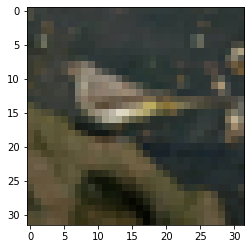

In [17]:
import matplotlib.pyplot as plt

batch_size = 100
test_loader_view = torch.utils.data.DataLoader(test_set, 
                                            batch_size=batch_size,
                                            shuffle=True, 
                                            num_workers=2)
sel = 0
for data in test_loader_view:
    for sel in range(batch_size):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.to(torch.float16)
        outputs = net_g(inputs)
        image = data[0][sel]/2+0.5
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        classes = test_set.classes
        print("Ans = {}".format(classes[data[1][sel]]),end=", ")
        print("LeNet_Ans = {}".format(classes[outputs.argmax(dim=1)[sel]]))
        plt.imshow(image)
        plt.show
    print((outputs.argmax(dim=1) == labels).float().mean())
    break

In [13]:
MODEL_HOME = "/home/y-neo/work2/workspace/docker/workspace/LeNet_CIFAR10"
model_path = MODEL_HOME + '/model.pth'

net_g.load_state_dict(torch.load(model_path))
LOG = []
LOG.append(model_path)

In [66]:
MODEL_HOME = "/home/y-neo/work2/workspace/docker/workspace/LeNet_CIFAR10"
model_path = MODEL_HOME + '/model_quant_int8.pth'
#torch.save(net_g.state_dict(), model_path)

In [20]:
import joblib
joblib.dump(net_g.conv1.weight.grad, "/home/y-neo/work2/workspace/auto_optim/new/grad/conv1_grad",compress=3)
joblib.dump(net_g.conv2.weight.grad, "/home/y-neo/work2/workspace/auto_optim/new/grad/conv2_grad",compress=3)
joblib.dump(net_g.fc1.weight.grad, "/home/y-neo/work2/workspace/auto_optim/new/grad/fc1_grad",compress=3)
joblib.dump(net_g.fc2.weight.grad, "/home/y-neo/work2/workspace/auto_optim/new/grad/fc2_grad",compress=3)
joblib.dump(net_g.fc2.weight.grad, "/home/y-neo/work2/workspace/auto_optim/new/grad/fc3_grad",compress=3)

['/home/y-neo/work2/workspace/auto_optim/new/grad/fc3_grad']

In [135]:
print(LOG)
epoch_test_acc, epoch_test_loss = test_grad(net_g, test_loader, train_loader, criterion, torch.float16)
print(f'test acc. {epoch_test_acc:.3f} test loss {epoch_test_loss:.3f}')

['/home/y-neo/work2/workspace/docker/workspace/LeNet_CIFAR10/model_training.pth', 'to int8']
test acc. 0.581 test loss 1.217


In [16]:
# to int8
net_g.conv1.weight.data = (net_g.conv1.weight.data*128).to(torch.int8).to(torch.float16)/128
net_g.conv2.weight.data = (net_g.conv2.weight.data*128).to(torch.int8).to(torch.float16)/128
net_g.fc1.weight.data = (net_g.fc1.weight.data*128).to(torch.int8).to(torch.float16)/128
net_g.fc2.weight.data = (net_g.fc2.weight.data*128).to(torch.int8).to(torch.float16)/128
net_g.fc3.weight.data = (net_g.fc3.weight.data*128).to(torch.int8).to(torch.float16)/128
LOG.append("to int8")

In [566]:
import copy
tmp_layer = copy.deepcopy(net_g.fc3.weight.data)

In [22]:
print(LOG)
print(net_g.conv1.weight.data[0]*128)

['/home/y-neo/work2/workspace/auto_optim/data_flex_c10/conv1_1.7_1/model_retrained.pth', 'to int8', 'to int8', 'to int8', 'to int8', 'to int8']
tensor([[[-30., -36., -48.,  -9.,   7.],
         [-44., -34.,   0.,  23.,   5.],
         [-24.,  -2.,   0.,   3.,   3.],
         [-35., -12., -22.,  -9., -36.],
         [-35., -23., -24., -25., -27.]],

        [[-28., -44., -24.,   1.,   0.],
         [-26., -14.,   0.,  22.,   2.],
         [ -5.,  10.,  30.,  15.,   0.],
         [  0.,   2.,   7., -11., -23.],
         [ -9.,  -1.,   7.,  -3., -44.]],

        [[ -2.,  -1.,  18.,  38.,  34.],
         [ -6.,  24.,  44.,  54.,  48.],
         [  4.,  44.,  52.,  53.,   9.],
         [ 37.,  40.,  42.,  37.,  -7.],
         [ 33.,  41.,  20.,  10., -17.]]], device='cuda:0',
       dtype=torch.float16)


In [473]:
print(LOG)
print(net_g.fc2.weight.data[83])

['/home/y-neo/work2/workspace/docker/workspace/LeNet_MNIST/model_quant_int8.pth', 'fc3_load']
tensor([ 0.0391, -0.0938,  0.0000,  0.0703,  0.1016,  0.0000, -0.0703,  0.0938,
         0.0078, -0.0781, -0.0078,  0.0078,  0.0625, -0.0781,  0.0078,  0.0469,
         0.0391,  0.0859,  0.0156, -0.0156,  0.0625, -0.0469, -0.0078,  0.0000,
        -0.0391, -0.0859, -0.0938, -0.0859,  0.0000, -0.0391,  0.0625, -0.0078,
        -0.0547,  0.0078,  0.0625,  0.0703,  0.0000, -0.0156,  0.1016,  0.0547,
         0.0469,  0.0547, -0.0312, -0.0469,  0.0938,  0.0547, -0.0859,  0.1094,
         0.0781,  0.0625,  0.0000,  0.0000,  0.0234,  0.0391,  0.1016, -0.0625,
        -0.1406, -0.0469,  0.0625,  0.0000, -0.0078, -0.0703,  0.0469, -0.0781,
         0.0000,  0.0469,  0.0000,  0.0000,  0.0156,  0.0312,  0.0781, -0.0312,
        -0.0938,  0.0000,  0.0000,  0.0625,  0.0547,  0.0312, -0.0703, -0.0625,
         0.0156,  0.0469,  0.1250, -0.0234,  0.0000, -0.0391,  0.0000, -0.0547,
        -0.0078,  0.0000, 

In [657]:
print(LOG)
print(net_g.conv2.weight.grad)

['/home/y-neo/work2/workspace/optim/model_quant_int8.pth', 'conv1_load', 'conv1_load', 'conv1_load', 'conv1_load', 'conv1_load', 'to int8', 'conv1_load', 'to int8', 'conv1_load', 'to int8', 'conv2_load']
tensor([[[[ 3.5229e-03,  5.1308e-03,  5.2834e-03,  2.7752e-03,  2.8443e-04],
          [ 5.6229e-03,  5.9738e-03,  5.9967e-03,  9.7418e-04, -3.2926e-04],
          [ 4.6921e-03,  3.3569e-03,  5.4665e-03, -1.6069e-04, -2.7561e-04],
          [ 2.0199e-03,  4.5538e-04,  2.2869e-03, -8.1348e-04,  1.3094e-03],
          [ 1.6963e-04,  4.0817e-04,  5.7554e-04, -6.4135e-04,  1.7681e-03]],

         [[ 2.2144e-03, -1.2655e-03, -2.7447e-03, -1.4715e-03,  1.6584e-03],
          [ 4.1318e-04, -1.9665e-03, -3.7060e-03,  2.3067e-04,  3.6278e-03],
          [-5.4359e-04,  3.2067e-04, -3.4904e-04,  1.9894e-03,  3.6774e-03],
          [ 7.8201e-04,  2.4395e-03,  1.2884e-03,  3.0861e-03,  3.1872e-03],
          [ 4.1962e-03,  4.0169e-03,  2.3346e-03,  4.0855e-03,  4.5166e-03]],

         [[ 8.2684e-04

In [588]:
print(LOG)
print(net_g.fc3.weight.grad[9])

['/home/y-neo/work2/workspace/docker/workspace/LeNet_MNIST/model_quant_int8.pth', 'to int8', 'fc3_load', 'to int8', 'fc3_load', 'fc3_load', 'fc3_load', 'fc3_load', 'fc3_load', 'fc3_load', 'fc3_load', 'fc3_load', 'fc3_load', 'fc3_load', 'fc3_load', 'fc3_load', 'fc3_load', 'fc3_load']
tensor([-4.8875e+01, -7.5250e+01, -1.2625e+01, -3.3184e+00, -1.9375e+02,
         8.4351e-02, -7.8562e+01, -5.3406e+01, -6.4438e+01, -1.4288e+02,
        -1.4086e+01, -9.9625e+01,  7.1960e-02, -1.6412e+02, -1.4038e+02,
        -4.6777e-01, -5.0625e+01, -1.6025e+02, -3.1359e+01,  4.3274e-02,
        -3.0900e+02, -1.0633e+01, -2.3975e+02, -1.0002e-02, -3.3625e+01,
         2.6758e-01, -8.6562e+01,  2.6886e-02, -9.9938e+01, -5.7465e-02,
        -2.4525e+02,  1.7578e-01, -1.5838e+02, -1.6925e+02, -2.6250e+02,
        -3.6125e+02, -1.5650e+02, -5.1844e+01, -1.1367e+01,  7.9590e-02,
        -6.8848e-02, -1.2850e+02, -3.3375e+02, -1.1256e+02,  8.0643e-03,
        -2.0225e+02, -5.1956e-03,  1.0828e-01, -1.2378e-01,

In [54]:
num = 0

In [72]:
conv1_optim = joblib.load("conv1_"+str(num).zfill(2))
for i in range(6):
    for j in range(5):
        for k in range(5):
            net_g.conv1.weight.data[i][0][j][k] = conv1_optim[i][0][j][k]
LOG.append("conv1_load")

FileNotFoundError: [Errno 2] No such file or directory: 'conv1_01'

In [80]:
import joblib
joblib.dump(net_g.conv1.weight.grad, "/home/y-neo/work2/workspace/optim/grad/conv1_grad",compress=3)
joblib.dump(net_g.conv2.weight.grad, "/home/y-neo/work2/workspace/optim/grad/conv2_grad",compress=3)
joblib.dump(net_g.fc1.weight.grad, "/home/y-neo/work2/workspace/optim/grad/fc1_grad",compress=3)
joblib.dump(net_g.fc2.weight.grad, "/home/y-neo/work2/workspace/optim/grad/fc2_grad",compress=3)
joblib.dump(net_g.fc3.weight.grad, "/home/y-neo/work2/workspace/optim/grad/fc3_grad",compress=3)

['/home/y-neo/work2/workspace/auto_optim/grad/fc3_grad']